In [1]:
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

[kret_np_pd.np_pd_nb_imports] Imported kret_np_pd.np_pd_nb_imports in 0.0177 seconds
Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env
[kret_matplotlib.mpl_nb_imports] Imported kret_matplotlib.mpl_nb_imports in 0.1423 seconds
[kret_polars.polars_nb_imports] Imported kret_polars.polars_nb_imports in 0.0571 seconds
[kret_rosetta.rosetta_nb_imports] Imported kret_rosetta.rosetta_nb_imports in 0.0000 seconds
[kret_lgbm.lgbm_nb_imports] Imported kret_lgbm.lgbm_nb_imports in 0.0000 seconds
[kret_sklearn.sklearn_nb_imports] Imported kret_sklearn.sklearn_nb_imports in 0.1069 seconds
[kret_torch_utils.torch_nb_imports] Imported kret_torch_utils.torch_nb_imports in 0.3210 seconds
[kret_lightning.lightning_nb_imports] Imported kret_lightning.lightning_nb_imports in 0.0011 seconds
[kret_tqdm.tqdm_nb_imports] Imported kret_tqdm.tqdm_nb_imports in 0.0000 seconds
[kret_type_hints.types_nb_imports] Imported kret_type_hints.types_nb_imports in 0.0004 seconds
[kret_utils.utils_nb_

# Load Data

In [3]:
df = pd.read_csv(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [5]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,int64,int64,object,float64,int64,object,object,float64
135,136,22,female,28.050,0,no,southeast,2155.682
542,543,63,female,36.300,0,no,southeast,13887.204
599,600,52,female,37.525,2,no,northwest,33471.972
715,716,60,male,28.900,0,no,southwest,12146.971
1099,1100,25,female,33.990,1,no,southeast,3227.121


## Cleanup

In [6]:
UKS_NP_PD.data_cleanup(df)

In [7]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,category,int64,category,float64,int64,bool,category,float64
110,111,54,male,33.630,1,False,northwest,10825.254
205,206,28,female,28.880,1,False,northeast,4337.735
348,349,36,female,29.920,1,False,southeast,5478.037
379,380,62,male,31.460,1,False,southeast,27000.985
394,395,46,female,32.300,2,False,northeast,9411.005


In [8]:
df.drop(["Id"], inplace=True, axis=1)

In [9]:
features = df.drop("charges", axis=1)
target = df["charges"]

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

## Scaler & OLS

In [10]:
dtt(features)

,age,sex,bmi,children,smoker,region
,int64,category,float64,int64,bool,category
393,49,male,31.350,1,False,northeast
508,24,female,25.270,0,False,northeast
715,60,male,28.900,0,False,southwest
885,32,male,28.930,1,True,southeast
982,31,male,25.900,3,True,southwest


In [11]:
float_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "region"]

In [12]:
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

column_transform = ColumnTransformer(
    transformers=[("scaler", power_transformer, float_cols), ("onehot", one_hot, cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)

In [13]:
steps = [("column_transform", column_transform)]

In [14]:
pipeline_x = PipelinePD(steps=steps)

In [15]:
x_train = pipeline_x.fit_transform_df(x_train)
x_val = pipeline_x.transform_df(x_val)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing onehot, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [16]:
dtt([x_train, x_val], n=2)

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
579,-0.993,-1.203,-1.072,1.000,0.000,1.000,0.000,0.000,0.000,False
803,-1.605,1.760,-1.072,1.000,0.000,0.000,0.000,1.000,0.000,True
,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
1034,1.467,1.225,-1.072,0.000,1.000,0.000,1.000,0.000,0.000,False
124,0.602,0.566,1.367,1.000,0.000,0.000,1.000,0.000,0.000,False


In [17]:
ols = LinearRegression()
ols.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [18]:
y_hat_train_ols = ols.predict(x_train)
resid_train = y_train - y_hat_train_ols
y_hat_val_ols = ols.predict(x_val)
resid_val = y_val - y_hat_val_ols

In [19]:
dtt([x_train, x_val, resid_train, resid_val], n=2)

age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 651 
 0.984 
 1.397 
 0.308 
 1.000 
 0.000 
 0.000 
 0.000 
 1.000 
 0.000 
 False 
 
 
 1079 
 1.584 
 0.527 
 1.367 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 False 
 
 
 
 
 
 
 age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 1272 
 0.338 
 -0.824 
 1.869 
 0.000 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 False 
 
 
 1190 
 -0.518 
 0.390 
 0.961 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 651 
 -3891.826 
 
 
 1079 
 -137.835 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 1272 
 6093.037 
 
 
 1190 
 -2649.227

## Build LGBM Dataset

In [24]:
x_train_ds = DatasetLGBM(x_train)

In [25]:
x_train_ds.set_categorical_feature(cat_cols)

In [26]:
# ds_params = {
#     "feature_name": list(X_train.columns),
#     "categorical_feature": cat_cols,
# }
# train_data = lgbm.Dataset(X_train, label=Y_train, **ds_params)
# test_data = lgbm.Dataset(X_val, label=Y_val, reference=train_data, **ds_params)
# train_data.get_feature_name()
# Implementation

## Train Model

In [27]:
raise ValueError("Stop")

ValueError: Stop

In [28]:
LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'num_leaves': 31,
 'max_depth': 7,
 'learning_rate': 0.1,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'n_jobs': -2,
 'bagging_fraction': 0.85,
 'feature_fraction': 0.85,
 'min_data_in_leaf': 20}

In [29]:
model = LGBMRegressor(**LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS)

In [30]:
fit_defaults = LGBM_Defaults.LGBM_FIT_DEFAULTS
fit_defaults

{'eval_metric': 'l2',
 'callbacks': [<lightgbm.callback._EarlyStoppingCallback at 0x10458b5c0>,
  <lightgbm.callback._RecordEvaluationCallback at 0x13faf2e40>]}

In [31]:
model.fit(x_train, resid_train, eval_set=[(x_val, resid_val)], **LGBM_Defaults.LGBM_FIT_DEFAULTS)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1137, number 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
LGBM_Defaults.EVAL_RECORDS

{'valid_0': OrderedDict([('l2',
               [np.float64(35328767.082793355),
                np.float64(35094110.325391985),
                np.float64(32363609.979229167),
                np.float64(32388512.87358532),
                np.float64(30152393.21556124),
                np.float64(28534521.624512848),
                np.float64(26510018.405024447),
                np.float64(24905647.336782575),
                np.float64(23652808.303602096),
                np.float64(22827377.587658126),
                np.float64(21941042.50217119),
                np.float64(21228548.598477427),
                np.float64(20971271.854482155),
                np.float64(20936743.999246743),
                np.float64(20362619.410138473),
                np.float64(20355685.205568366),
                np.float64(20322854.032737628),
                np.float64(20312848.876486767),
                np.float64(19929286.276428368),
                np.float64(19525049.82260388),
            

In [33]:
# model = lgb.train(
#     params=LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS,  # type:ignore[arg-type]
#     train_set=train_data,
#     valid_sets=[test_data],
#     num_boost_round=1000,
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
# )

# NOTE ^ bad performance

In [34]:
y_pred_resid = model.predict(x_val)
y_hat = y_pred_resid + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [35]:
gs = GroupScatterUKS(y_val, y_hat)

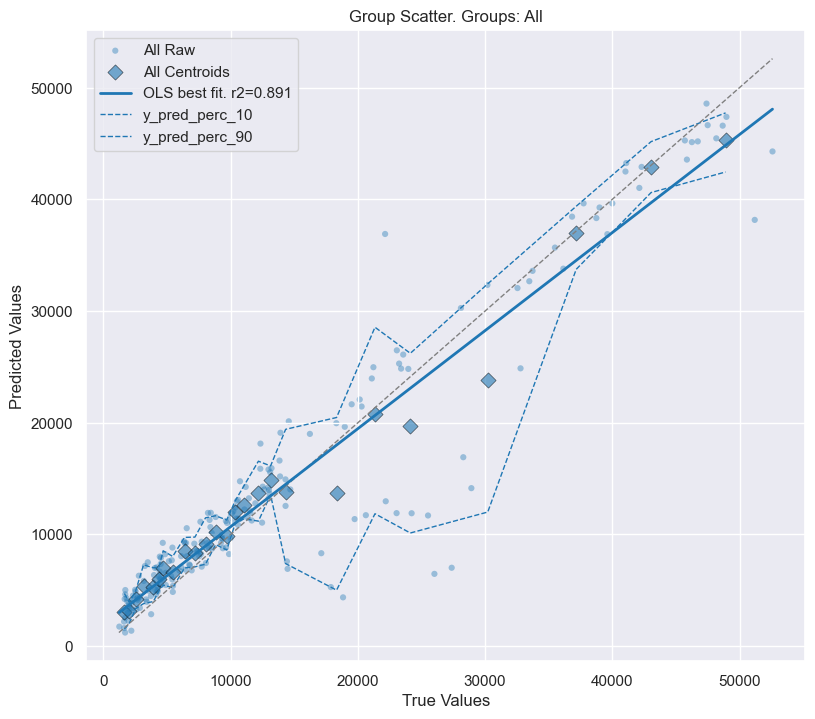

In [36]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))

# Sandbox

In [37]:
gs_resid = GroupScatterUKS(resid_val, y_pred_resid)

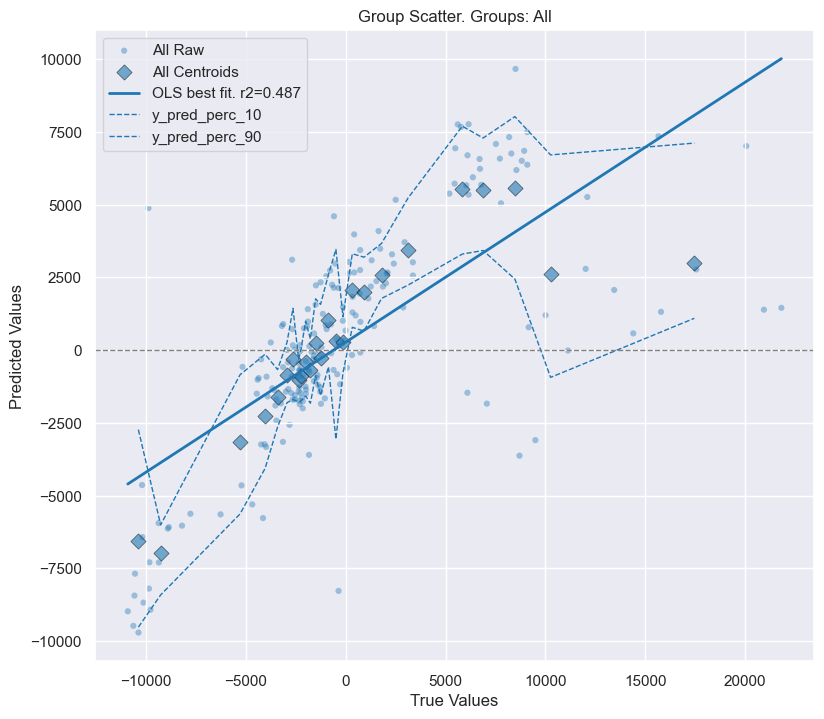

In [38]:
gs_resid.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="y_0")

In [39]:
gs_ols = GroupScatterUKS(y_val, y_hat_val_ols)

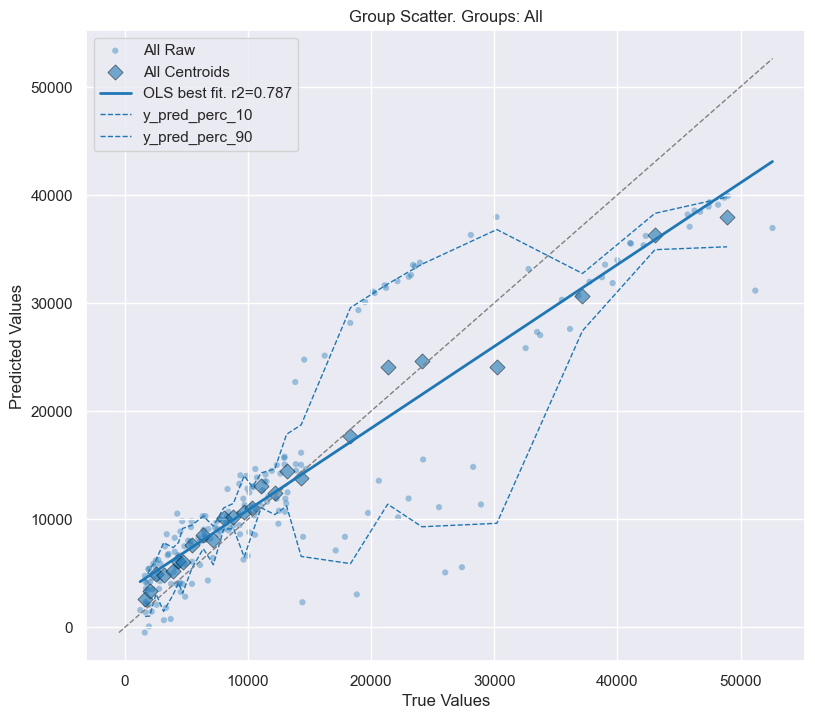

In [40]:
gs_ols.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="identity")

# Save & Load

## Save

In [ ]:
import joblib

In [ ]:
joblib.dump(model, UKS_CONSTANTS.LGBM_MODEL_WEIGHT_DIR / "lgbm_model.pkl")

['/Users/Akseldkw/coding/data_kretsinger/lgbm/lgbm_model.pkl']

## Load

In [ ]:
model_loaded: LGBMRegressor = joblib.load(UKS_CONSTANTS.LGBM_MODEL_WEIGHT_DIR / "lgbm_model.pkl")

In [51]:
model_loaded

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
y_pred_resid_loaded = model_loaded.predict(x_val)
y_hat_loaded = y_pred_resid_loaded + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [53]:
gs_loaded = GroupScatterUKS(y_val, y_hat_loaded)

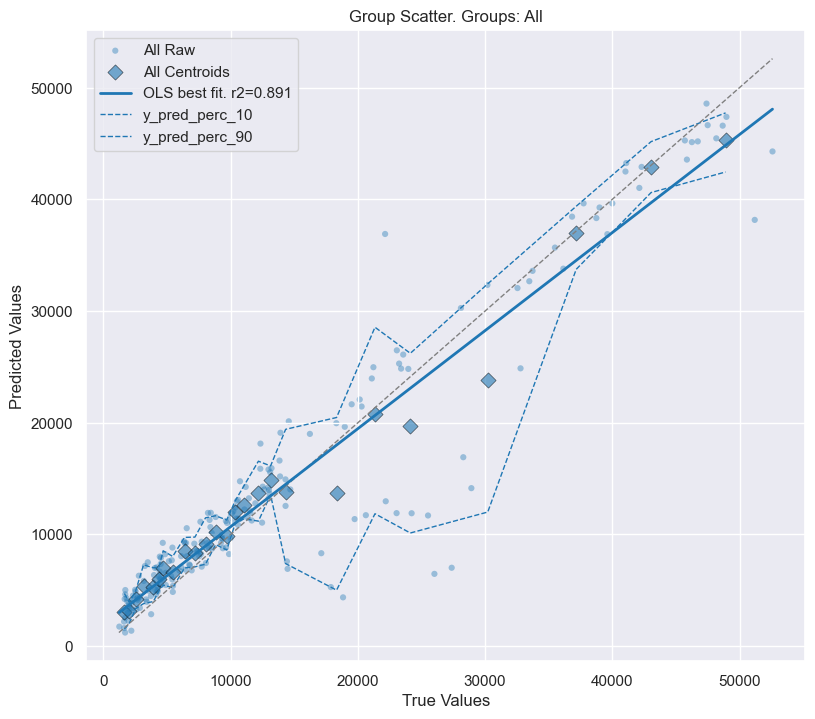

In [54]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))